# Import libraries and modules

In [194]:
from Environments import *
# from DQN import *

# Define the settings of the environment

In [195]:
class Settings:
    """Define settings of the environment such as course shape, course characteristics
       possible actions, position, neural-network parameters and training parameters

    Example usage:
        > settings = Settings()
    """
    def __init__(self):
        # Define road segments, this whole sequence is an ellipsis course
        # Starts with straight horizontal line, draw elliptical section
        # then another straight line and then close with another ellipsis
        self.road_segments = [
            {
                'x': lambda t: t,
                'y': lambda t: 0.000001*t,
                't_start': 0,
                't_end': 10
            },
            {
                'x': lambda t: 10 + 5 * sp.sin(np.pi * (t - 10)),
                'y': lambda t: 5-5 * sp.cos(np.pi * (t - 10)),
                't_start': 10,
                't_end': 11
            },
            {
                'x': lambda t: 21-t,
                'y': lambda t: 8 +2*sp.cos(np.pi * (t - 11)/10),
                't_start': 11,
                't_end': 21
            },
            {
                'x': lambda t: 3 * sp.sin(np.pi * (t - 20)),
                'y': lambda t: 3 - 3 * sp.cos(np.pi * (t - 20)),
                't_start': 21,
                't_end': 22
            }
        ]
        # Define road parameters such as width and length
        self.road_width    = 1
        self.road_length   = 15
        # Closed is a boolean that indicates whether the circuit is closed
        # (I presume)
        self.closed        = False
        # Road resolutions refers to how coarse the grid that constitutes the
        # course is (affects number of states)
        self.road_resolution = 100


        # car settings

        # car initial position
        self.init_car_x = 4
        self.init_car_y = 0
        self.init_car_theta = 0

        self.init_car_speed = .25

        #sensors
        self.n_sensors = 7
        self.resolution = .1
        self.max_sensor_range = 5

        #actions
        self.action_dim = 7  # Actions for steering
        self.actions = 0.5*np.linspace(-1,1,self.action_dim)

        ## NN
        self.state_dim = self.n_sensors  * self.max_sensor_range / self.resolution   # State dimension is the number of sensor
        self.hidden_layers = [32, 16]
        # Define the gamma and alpha
        self.gamma  = .95
        self.alpha  = .95

        # training
        self.epsilon = 0.05
        self.learning_rate      = 0.001
        self.num_episodes = 100

In [196]:
# Machine Learning and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import os
import subprocess
import sys

def get_device():
    if 'COLAB_TPU_ADDR' in os.environ:
        print("TPU detected. Setting up TPU...")
        try:
            import torch_xla.core.xla_model as xm
            return xm.xla_device()
        except ImportError:
            print("TPU libraries not found. Installing required packages...")
            subprocess.check_call([sys.executable, "-m", "pip", "install",
                                   "cloud-tpu-client==0.10",
                                   "torch==1.13.0",
                                   "https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl"])
            import torch_xla.core.xla_model as xm
            return xm.xla_device()
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


class PolicyNetwork1(nn.Module):
    def __init__(self, road_env, carenv, settings, train_mode):
        self.road_env = road_env
        self.carenv = carenv
        self.settings = settings
        self.train_mode = train_mode

        # Define the device
        self.device = get_device()

        # Define the neural network
        super(PolicyNetwork1, self).__init__()

        # Create a list to hold all layers
        layers = []

        # Input layer
        layers.append(nn.Linear(self.settings.n_sensors, self.settings.hidden_layers[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(self.settings.hidden_layers) - 1):
            layers.append(nn.Linear(self.settings.hidden_layers[i], self.settings.hidden_layers[i + 1]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(self.settings.hidden_layers[-1], self.settings.action_dim))

        # Combine all layers
        self.model = nn.Sequential(*layers).to(self.device)

    def forward(self, state):
        return self.model(state)


    def get_action(self, state): # epsilon greedy
        if np.random.rand() < self.settings.epsilon:
            return np.random.choice(self.settings.actions)
        else:
            state = torch.FloatTensor(state).to(self.device)
            with torch.no_grad():
                action = self.forward(state)
            action = torch.argmax(action).item()
            return action

    def train(self, num_episodes):
        all_rewards = []
        plot_training_progress(all_rewards, first=True)

        # we can add more complex trainig rate scheduling
        optimizer = optim.Adam(self.model.parameters(), lr=self.settings.learning_rate)
        criterion = nn.MSELoss()

        for episode in range(num_episodes):
            total_reward = 0

            state = self.carenv.car_reset()
            state = torch.FloatTensor(self.car_env.get_state()).to(self.device)

            while not self.car_env.Terminal:
                action = self.get_action(state)
                next_state, reward = self.car_env.step(self.car_env.actions[action])
                next_state = torch.FloatTensor(next_state).to(self.device)

                total_reward += reward

                # Compute Q(s, a):
                Q_values = self.forward(state)
                Q_value = Q_values[action]

                # Compute Q(s', a')
                with torch.no_grad():
                   next_Q_values = self.forward(next_state)
                   next_Q_value = torch.max(next_Q_values)

                # Compute the target Q value
                target_Q_value = reward + self.settings.gamma * next_Q_value*(1 - self.car_env.Terminal)
                expected_Q_value = Q_value.clone()
                expected_Q_value[0, action] = target_Q_value

                # Compute the loss
                loss = criterion(Q_values, expected_Q_value)

                # Update the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                state = next_state

            all_rewards.append(total_reward)
            if episode % 10 == 0:
                plot_training_progress(all_rewards, first=False)

        #save the model and the settings
        torch.save(self.settings, 'car_policy_settings.pth')
        torch.save(self.model.state_dict(), 'car_policy_model.pth')
        print('Model and Settings saved successfully')

def plot_training_progress(all_rewards, first):
    if first:
        fig, ax = plt.subplots(figsize=(20, 7))
        line, = ax.plot([], [])
        ax.set_xlabel('Episode')
        ax.set_ylabel('Total Reward')
        ax.set_title('Training Progress')
    else:
        if 'line' not in locals():
            line, = ax.plot([], [])
        line.set_xdata(range(len(all_rewards)))
        line.set_ydata(all_rewards)
        ax.relim()
        ax.autoscale_view()
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.1)

# Create the settings and environment objects

In [197]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings, roadenv)
NN = PolicyNetwork1(roadenv, carenv, settings, train_mode=True)

NameError: name 'settings' is not defined

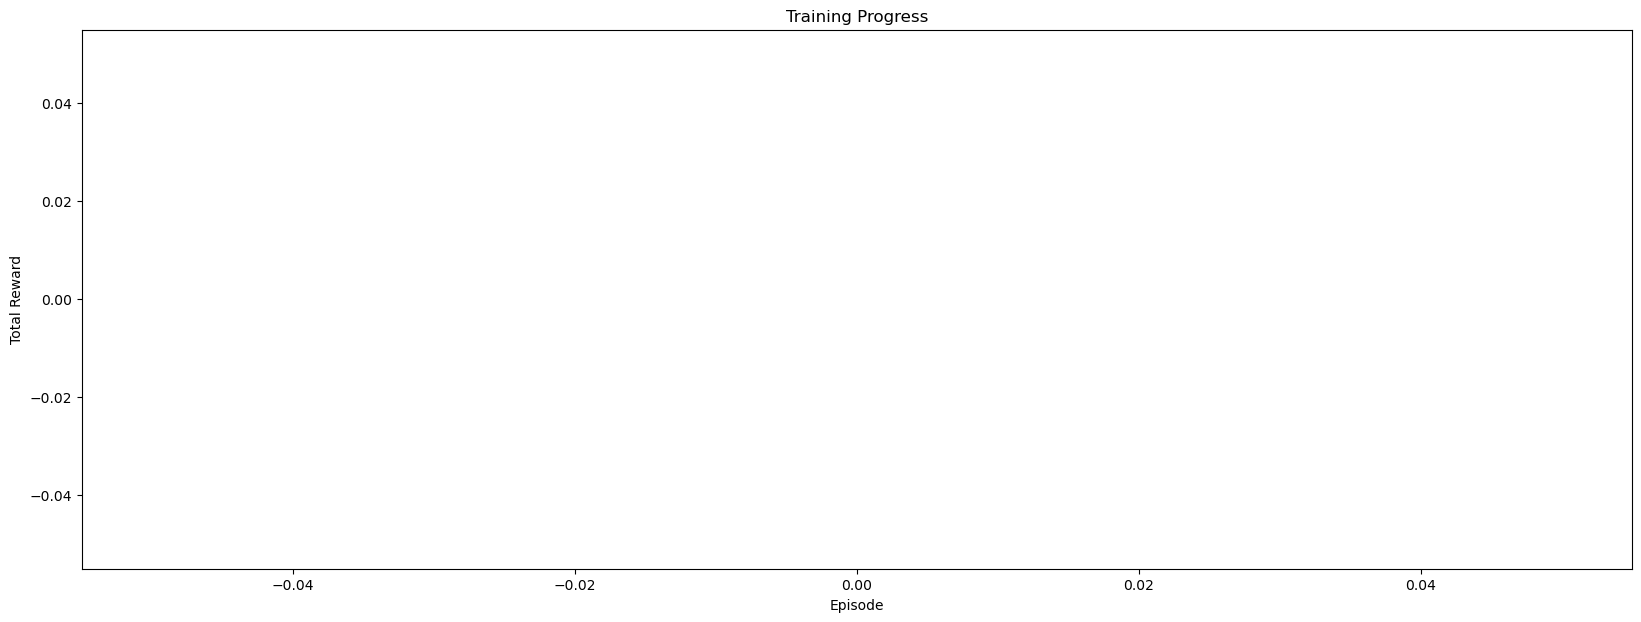

In [198]:
NN.train(10)